# Gold Recovery Project

## Project description                              

In this project, we are tasked with building a machine leraning model.

The model should predict the amount of gold extracted from the gold mineral. The model should help optimize the production and eliminate unprofitable parameters.

The model should help to increase the gold recovery rate and reduce the loss of gold.

## Libraries

In [1]:
import pandas as pd
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

## Data preprocessing

### Datasets

In [2]:
df_train = pd.read_csv('datasets/gold_recovery_train.csv')
df_test = pd.read_csv('datasets/gold_recovery_test.csv')
df_full = pd.read_csv('datasets/gold_recovery_full.csv')

One of our tasks for this proyect is to make sure that the data in "rougher.output.recovery" is correct so we aregoing to do that with the help of the formula:

Recovery = C * (F - T) / F * (C - T) * 100%

Where: 
- C is the proportion of gold in the concentrate right after flotation (rougher.output.concentrate_au) or after the purification stage (final.output.concentrate_au)
- F is the proportion of gold in the feed before flotation (rougher.input.feed_au) or after the purification stage (final.output.concentrate_au)
- T is the proportion of gold in the tailings after flotation (rougher.output.tail_au) or after the purification stage (final.output.tail_au)



In [3]:
df_train['rougher.output.recovery']

0        87.107763
1        86.843261
2        86.842308
3        87.226430
4        86.688794
           ...    
16855    89.574376
16856    87.724007
16857    88.890579
16858    89.858126
16859    89.514960
Name: rougher.output.recovery, Length: 16860, dtype: float64

Lets calculate the recovery for the training set and the test set.

In [4]:
def recovery_calc(row):
    numerator = row['rougher.output.concentrate_au']*(row['rougher.input.feed_au']-row['rougher.output.tail_au'])
    denominator = row['rougher.input.feed_au']*(row['rougher.output.concentrate_au']-row['rougher.output.tail_au'])
    if denominator == 0:
        return 0
    else:
        return numerator/denominator*100
    
df_train['recovery'] = df_train.apply(lambda x: recovery_calc(x), axis = 1)

MAE = (df_train['recovery'] - df_train['rougher.output.recovery']).abs().mean()
MAE


9.303415616264301e-15

We have a pretty low MAE for the training set so we can say that the data in "rougher.output.recovery" is correct.

Another task for this proyect is to analyze the features not available in the test set. So we are going to do that.

In [5]:
missed_test_columns = set(list(df_train.columns.values))-set(list(df_test.columns.values))
missed_test_columns

{'final.output.concentrate_ag',
 'final.output.concentrate_au',
 'final.output.concentrate_pb',
 'final.output.concentrate_sol',
 'final.output.recovery',
 'final.output.tail_ag',
 'final.output.tail_au',
 'final.output.tail_pb',
 'final.output.tail_sol',
 'primary_cleaner.output.concentrate_ag',
 'primary_cleaner.output.concentrate_au',
 'primary_cleaner.output.concentrate_pb',
 'primary_cleaner.output.concentrate_sol',
 'primary_cleaner.output.tail_ag',
 'primary_cleaner.output.tail_au',
 'primary_cleaner.output.tail_pb',
 'primary_cleaner.output.tail_sol',
 'recovery',
 'rougher.calculation.au_pb_ratio',
 'rougher.calculation.floatbank10_sulfate_to_au_feed',
 'rougher.calculation.floatbank11_sulfate_to_au_feed',
 'rougher.calculation.sulfate_to_au_concentrate',
 'rougher.output.concentrate_ag',
 'rougher.output.concentrate_au',
 'rougher.output.concentrate_pb',
 'rougher.output.concentrate_sol',
 'rougher.output.recovery',
 'rougher.output.tail_ag',
 'rougher.output.tail_au',
 'roug

We have 34 features in the training set and 52 in the test set. So we have 18 features that are not available in the test set.

But we can see that all of the features that are not available in the test set are in the "calculation" section of the process. So we can say that the features that are not available in the test set are calculated later in the process.

## EDA

In [6]:
df_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,recovery
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,87.107763
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,86.843261
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,86.842308
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,87.226430
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,86.688794


In [7]:
df_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,...,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,...,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,...,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,...,12.033091,-498.350935,8.074946,-499.474407,7.897085,-500.868509,4.931400,-499.963623,24.948919,-498.709987
4,2016-09-01 04:59:59,199.099327,10.682530,7.530000,0.805575,1401.268123,-500.808305,1398.128818,-499.504543,1402.172226,...,12.025367,-500.786497,8.054678,-500.397500,8.107890,-509.526725,4.957674,-500.360026,25.003331,-500.856333


In [8]:
df_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


- To fully undestarnd the data, we need to know the process of gold extraction. so we will start with a brief description of the process.

       Gold extraction process

              The gold extraction process consists of 2 stages:

              1. Flotation
              2. Purification

              The last one has 2 stages:

              1. First process
              2. Second process


- Visual representation of the process:


       ```
       Gold ore mixture
               |
          Flotation
               |
       Rougher Concentrate -------------------
               |                              |
               |                              |
               |                              |
       First cleaning stage  -----------------|
               |                              |
       Second cleaning stage -----------------|
               |                              |
          Final Concentrate               Rougher Tails
``


The columns are named according to the stage and the parameter type. [stage].[parameter_type].[parameter_name]

Stages:

- rougher - flotation
- primary_cleaner - first cleaning
- secondary_cleaner - second cleaning
- final - final concentrate

parameter_type:

- input - raw material
- output - product
- state - parameters characterizing the current state of the material, which are feed, concentrate and tail.
- calculation - calculation characteristics

parameter_name:

- ag - silver
- au - gold
- pb - lead
- sol - solid

This is are some examples:  

- final.output.concentrate_ag - final concentrate of silver
- secondary_cleaner.state.floatbank4_b_air - air flow in the fourth cleaning section
- rougher.input.feed_au - gold content in the rougher feed






In [9]:
print(df_train.info())
print()
print('Null values in df_train:')
print(df_train.isnull().sum())
print()
print('We have', df_train.duplicated().sum(), 'duplicated rows in df_train')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 88 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 non-null  float64


### Fill in missing values

We can see that our columns have some missing values but the proyect also tell us that parameters that are close in time they norlmaly have similar values. So knowing that we can use the method ffill to fill the missing values.

In [10]:
df_train = df_train.fillna(method='ffill')
df_test = df_test.fillna(method='ffill')
df_full = df_full.fillna(method='ffill')


## Analyze the data

### Concentrations of metals (Au, Ag, Pb) change depending on the purification stage

For this part of the proyect we are going to analyze the concentrations of metals (Au, Ag, Pb) at different stages.

We are going to start with the concentration of gold (Au).

In [11]:
au_columns = [col for col in df_train.columns if 'concentrate_au' in col or 'feed_au' in col]
au_df = df_train[au_columns]

au_df


,final.output.concentrate_au,primary_cleaner.output.concentrate_au,rougher.input.feed_au,rougher.output.concentrate_au
0,42.192020,34.174427,6.486150,19.793808
1,42.701629,34.118526,6.478583,20.050975
2,42.657501,33.969464,6.362222,19.737170
3,42.689819,28.260743,6.118189,19.320810
4,42.774141,33.044932,5.663707,19.216101
...,...,...,...,...
16855,46.713954,32.940215,5.335862,18.603550
16856,46.866780,32.925325,4.838619,18.441436
16857,46.795691,31.856742,4.525061,15.111231
16858,46.408188,30.770892,4.362781,17.834772



Now that we have the concentration of gold at different stages we can see that the concentration of gold increases with each stage, but we need to see it in a more visual way.

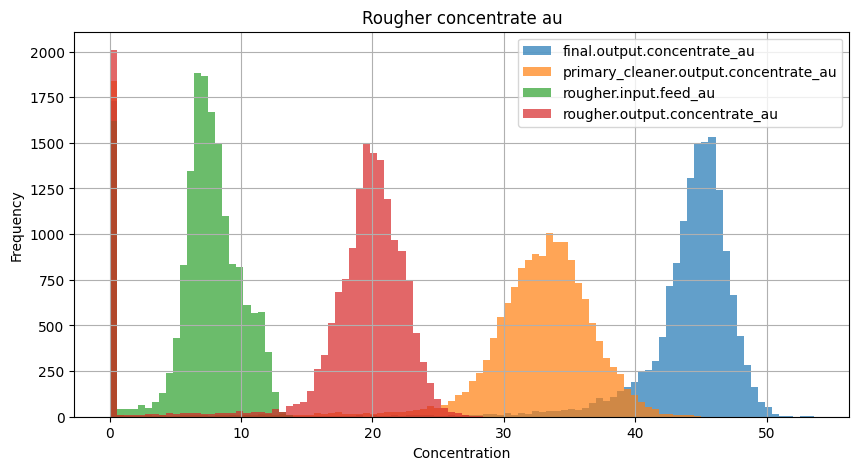

In [12]:
au_df.plot(kind='hist', bins=100, figsize=(10, 5), grid=True, legend=True, alpha=0.7)
plt.title('Rougher concentrate au')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()

Here we can see more clearly that at each stage has more gold than the previous one. Also we that the amount of gols is more than double at the final stage than at the rougher stage.

Now lets see the concentration of silver (Ag) at different stages.

In [13]:

ag_columns = [col for col in df_train.columns if 'concentrate_ag' in col or 'feed_ag' in col]
ag_df = df_train[ag_columns]

ag_df

,final.output.concentrate_ag,primary_cleaner.output.concentrate_ag,rougher.input.feed_ag,rougher.output.concentrate_ag
0,6.055403,8.547551,6.100378,11.500771
1,6.029369,8.558743,6.161113,11.615865
2,6.055926,8.603505,6.116455,11.695753
3,6.047977,7.221879,6.043309,11.915047
4,6.148599,9.089428,6.060915,12.411054
...,...,...,...,...
16855,3.224920,6.559174,6.091855,11.124896
16856,3.195978,6.612376,6.121323,11.425983
16857,3.109998,7.128896,5.970515,8.523497
16858,3.367241,7.490444,6.048130,11.658799


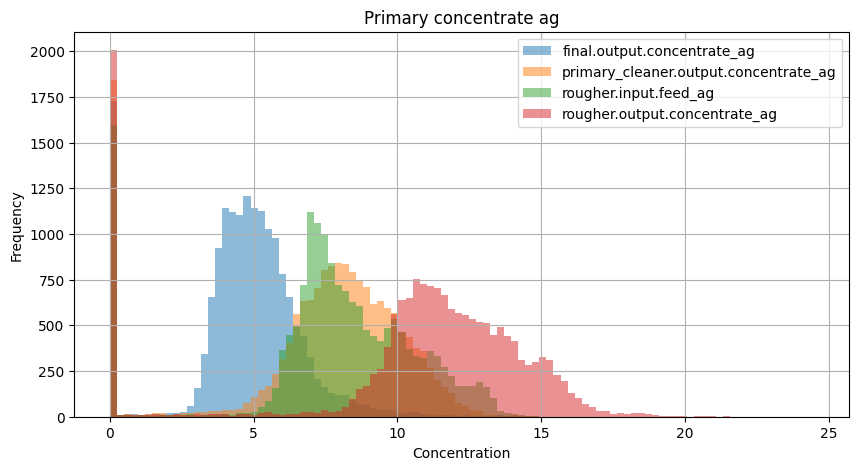

In [14]:

ag_df.plot(kind='hist', bins=100, figsize=(10, 5), grid=True, legend=True, alpha=0.5)
plt.title('Primary concentrate ag')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()

In this we can see that the concentration of silver increases with the first stage and then decreases with the second stage. This could tell us something about the process in the rougher stage, that makes the concentration of silver increase. But we can't be sure about that.

In [15]:
pb_columns = [col for col in df_train.columns if 'concentrate_pb' in col or 'feed_pb' in col]
pb_df = df_train[pb_columns]

pb_df

,final.output.concentrate_pb,primary_cleaner.output.concentrate_pb,rougher.input.feed_pb,rougher.output.concentrate_pb
0,9.889648,10.389648,2.284912,7.101074
1,9.968944,10.497069,2.266033,7.278807
2,10.213995,10.354494,2.159622,7.216833
3,9.977019,8.496563,2.037807,7.175616
4,10.142511,9.986786,1.786875,7.240205
...,...,...,...,...
16855,11.356233,12.445966,4.617558,10.984003
16856,11.349355,12.623947,4.144989,10.888213
16857,11.434366,12.633558,4.020002,8.955135
16858,11.625587,12.012378,3.902537,10.655377


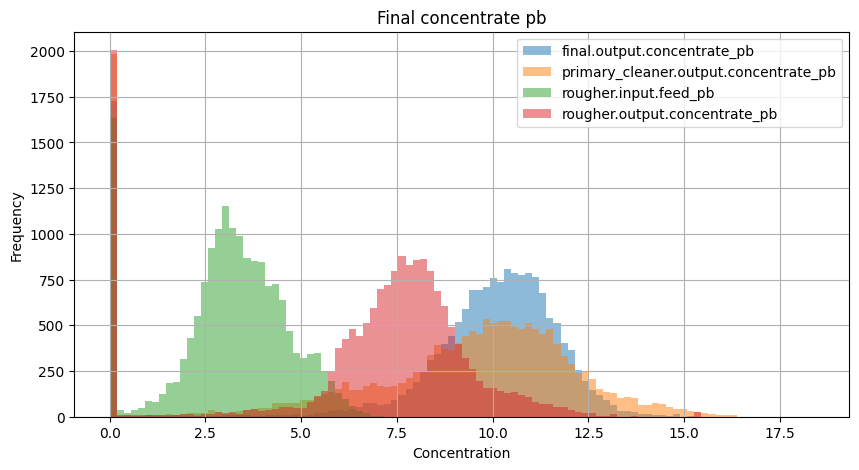

In [16]:

pb_df.plot(kind='hist', bins=100, figsize=(10, 5), grid=True, legend=True, alpha=0.5)
plt.title('Final concentrate pb')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()

The input feed is obviousley the biggest one because it is the raw material. The rougher concentrate is the second biggest one because it is the first stage of the process, but we see that both final and primary_cleaner concentrate have similar values.

### Feed particle size.

In this part of the proyect we are going to compare the feed particle size distributions in the train and test sets.

In [17]:
df_train_in_particles_columns = [col for col in df_train.columns if 'feed_size' in col] # Here we are looking for columns with 'feed_size' in their names
df_train_in_particles = df_train[df_train_in_particles_columns] # Here we are creating a new dataframe with only columns with 'feed_size' in their names

df_train_in_particles

,primary_cleaner.input.feed_size,rougher.input.feed_size
0,7.25,55.486599
1,7.25,57.278666
2,7.25,57.510649
3,7.25,57.792734
4,7.25,56.047189
...,...,...
16855,6.50,85.718304
16856,6.50,119.499241
16857,6.50,122.262690
16858,6.50,123.742430


In [18]:
df_test_in_particles_columns = [col for col in df_test.columns if 'feed_size' in col] # Here we are looking for columns with 'feed_size' in their names but in df_test
df_test_in_particles = df_test[df_test_in_particles_columns] # Here we are creating a new dataframe with only columns with 'feed_size' in their names

df_test_in_particles

,primary_cleaner.input.feed_size,rougher.input.feed_size
0,8.080000,62.710452
1,8.080000,61.961163
2,7.786667,66.903807
3,7.640000,59.865919
4,7.530000,63.315324
...,...,...
5851,8.070000,66.758479
5852,8.070000,62.560684
5853,8.070000,73.647513
5854,8.070000,78.066446


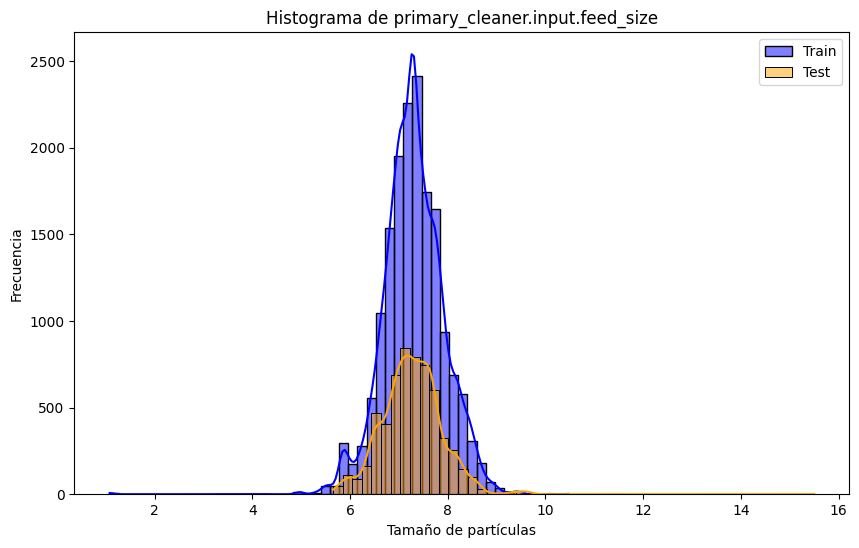

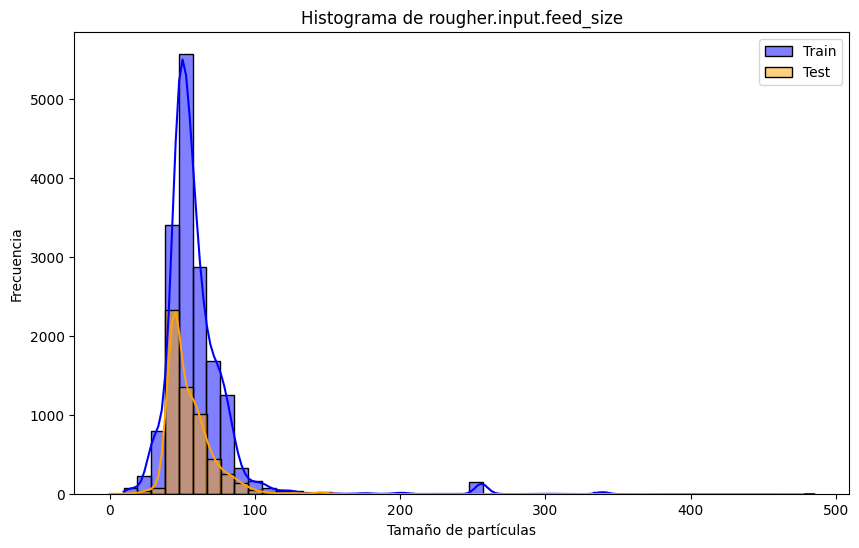

In [19]:
for column in df_train_in_particles:
    plt.figure(figsize=(10, 6))
    sns.histplot(df_train[column], bins=50, color='blue', kde=True, label='Train')
    sns.histplot(df_test[column], bins=50, color='orange', kde=True, label='Test')
    plt.title('Histograma de ' + column)
    plt.xlabel('Tamaño de partículas')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()


We can see that the distribution of the feed particle size in the train and test sets are very similar, just the train set has more data.

### Total concentrations of all substances at different stages.

##### Rougher feed

['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate']


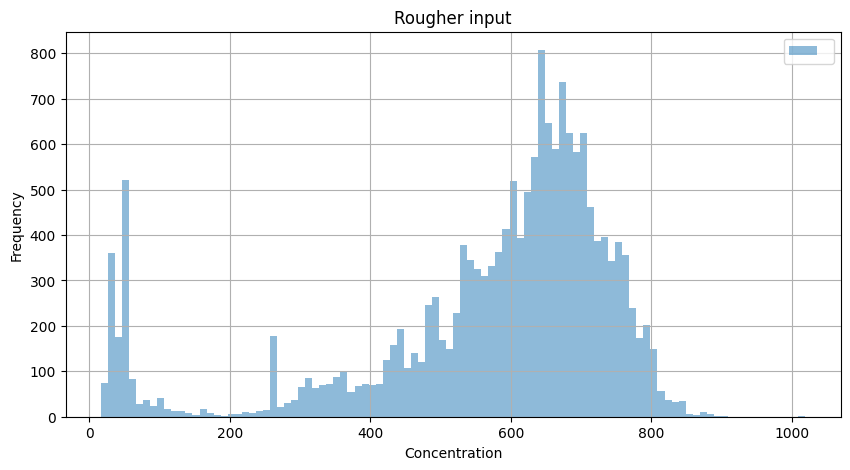

0        666.550126
1        669.214076
2        674.390106
3        687.166969
4        678.750244
            ...    
16855    733.866621
16856    765.282598
16857    764.305056
16858    753.516011
16859    734.834005
Length: 16860, dtype: float64


In [20]:
df_train_raw_input = [col for col in df_train.columns if 'rougher.input' in col] # Here we are looking for columns with 'rougher.input' in their names in df_train and creating a list with them
df_train_raw = df_train[df_train_raw_input].sum(axis=1) # Here we are summing all the columns with 'rougher.input' in their names

print(df_train_raw_input)

df_train_raw.plot(kind='hist', bins=100, figsize=(10, 5), grid=True, legend=True, alpha=0.5)
plt.title('Rougher input')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()

print(df_train_raw)


##### Rougher concentrate

['rougher.output.concentrate_ag', 'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol', 'rougher.output.concentrate_au']


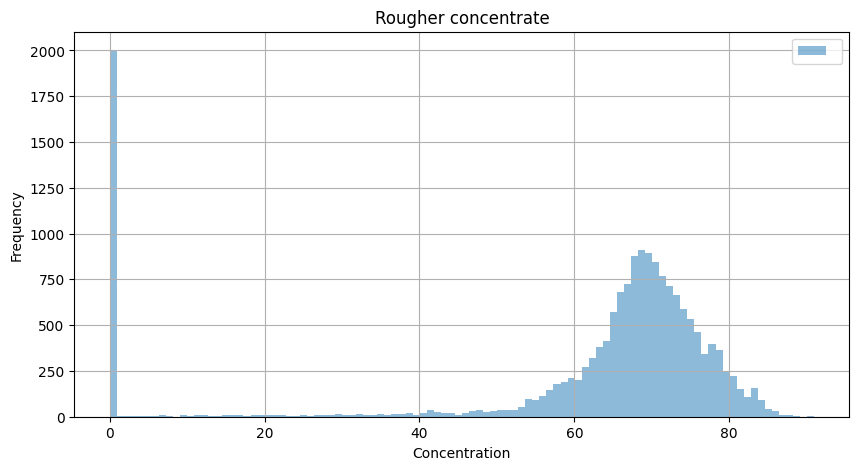

In [21]:
df_train_concentrate_input = [col for col in df_train.columns if 'rougher.output.concentrate' in col] # Here we are looking for columns with 'rougher.input' in their names in df_train and creating a list with them
df_train_concentrate = df_train[df_train_concentrate_input].sum(axis=1) # Here we are summing all the columns with 'rougher.input' in their names

print(df_train_concentrate_input)

df_train_concentrate.plot(kind='hist', bins=100, figsize=(10, 5), grid=True, legend=True, alpha=0.5)
plt.title('Rougher concentrate')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()

##### Final concentrate

['final.output.concentrate_ag', 'final.output.concentrate_pb', 'final.output.concentrate_sol', 'final.output.concentrate_au']


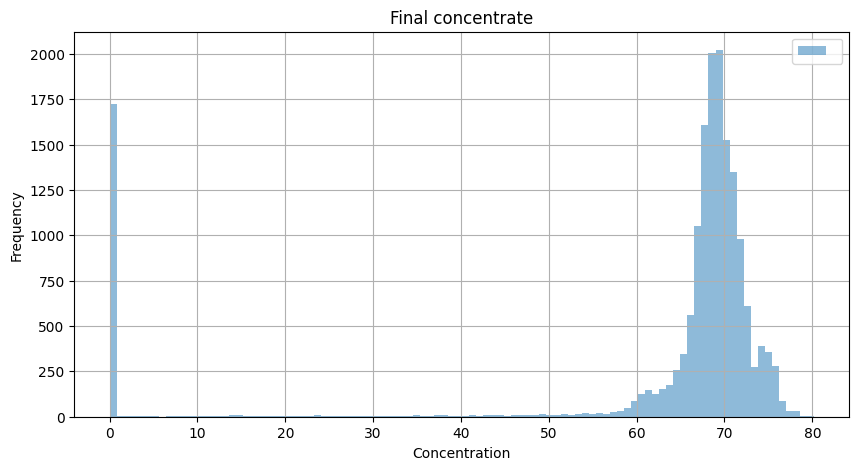

In [22]:
df_train_concentrate_final_output = [col for col in df_train.columns if 'final.output.concentrate' in col] # Here we are looking for columns with 'rougher.input' in their names in df_train and creating a list with them
df_train_concentrate_final = df_train[df_train_concentrate_final_output].sum(axis=1) # Here we are summing all the columns with 'rougher.input' in their names

print(df_train_concentrate_final_output)

df_train_concentrate_final.plot(kind='hist', bins=100, figsize=(10, 5), grid=True, legend=True, alpha=0.5)
plt.title('Final concentrate')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()


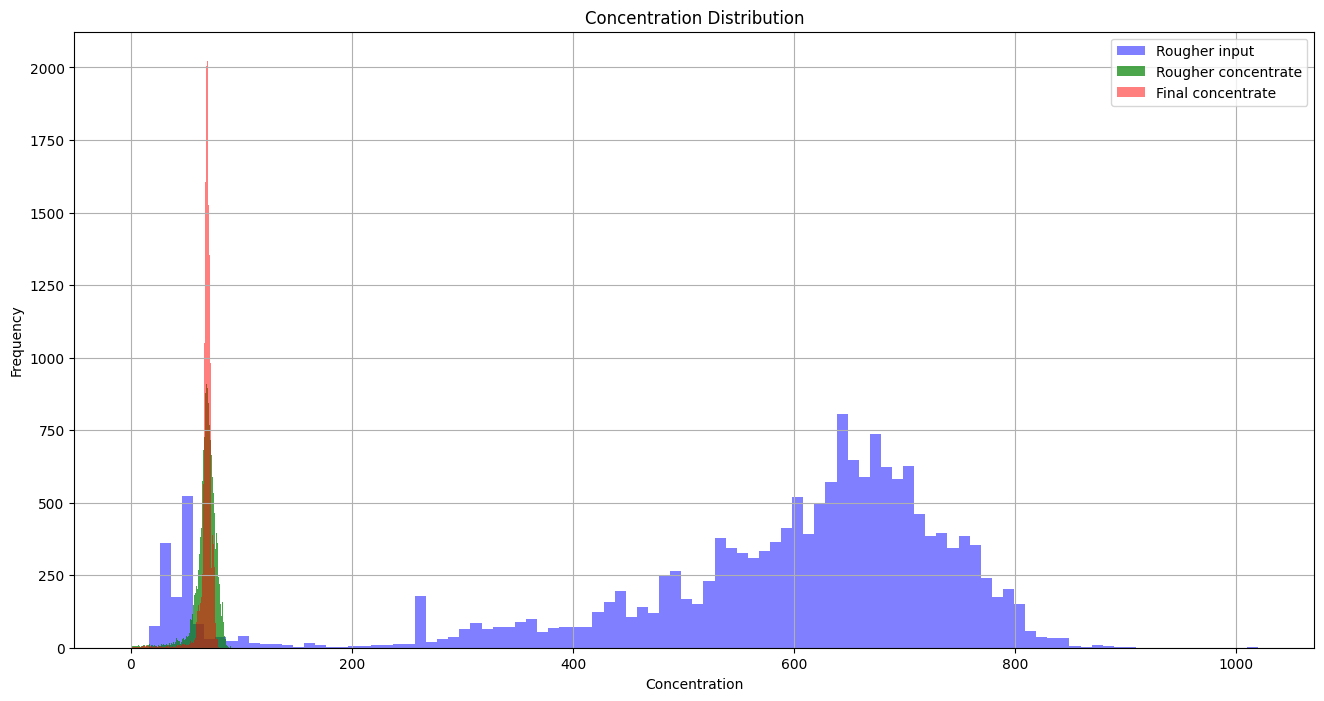

In [23]:
plt.figure(figsize=(16, 8))
plt.hist(df_train_raw, bins=100, alpha=0.5, label='Rougher input', color='blue')
plt.hist(df_train_concentrate, bins=100, alpha=0.7, label='Rougher concentrate', color='green')
plt.hist(df_train_concentrate_final, bins=100, alpha=0.5, label='Final concentrate', color='red')

plt.title('Concentration Distribution')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.legend()

plt.grid(True)
plt.show()


After looking at this graphs we can say that the distribution of the total amount of concentrations of all the stages have a normal distribution, but have some anormal values always near the 0.

Looking at the graphs together we can see that rougher input feed is the one with the most anormal values, so we are going to do a IQR test to see if we can remove this anormal values.

### Handling anormal values.

#### Rougher feed

##### IQR test

In [24]:
Q1 = df_train_raw.quantile(0.25)
Q3 = df_train_raw.quantile(0.75)
IQR = Q3 - Q1

print('This is the IQR:', IQR)


This is the IQR: 180.10835549931153


Loking at this we are going to remove the anormal values that are near the 0. and we will do that the rougher input feed. Because as we saw is the one with the most anormal values.

##### Removing anormal values

['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate']


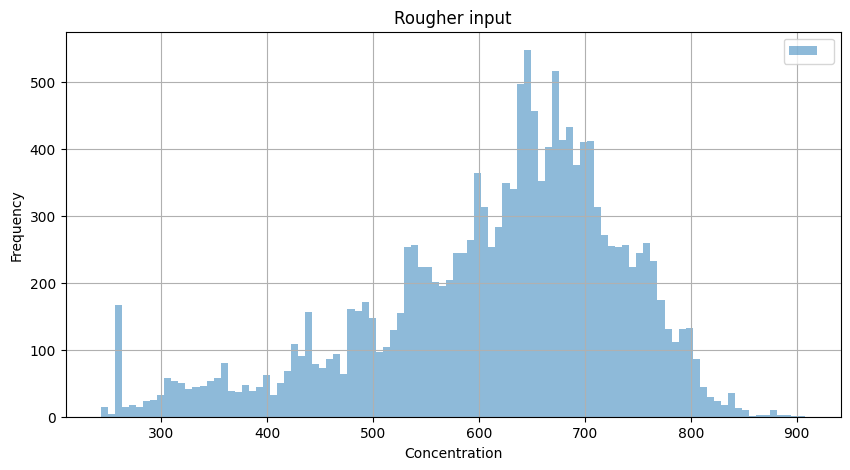

0        666.550126
1        669.214076
2        674.390106
3        687.166969
4        678.750244
            ...    
16855    733.866621
16856    765.282598
16857    764.305056
16858    753.516011
16859    734.834005
Length: 15392, dtype: float64


In [25]:

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outlier_indices = df_train_raw[(df_train_raw < lower_bound) | (df_train_raw > upper_bound)].index

df_train_1 = df_train.drop(outlier_indices)

remaining_indices = df_train_1.index

df_train_raw_input_filtered = [col for col in df_train_1.columns if 'rougher.input' in col] # Here we are looking for columns with 'rougher.input' in their names in df_train and creating a list with them
df_train_raw_filtered = df_train_1[df_train_raw_input_filtered].sum(axis=1) # Here we are summing all the columns with 'rougher.input' in their names

print(df_train_raw_input_filtered)

df_train_raw_filtered.plot(kind='hist', bins=100, figsize=(10, 5), grid=True, legend=True, alpha=0.5)
plt.title('Rougher input')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()

print(df_train_raw_filtered)



Now we can see a more clear normal distribution.

#### Rougher Concentrate

##### IQR test

In [26]:
Q_1 = df_train_concentrate.quantile(0.25)
Q_2 = df_train_concentrate.quantile(0.75)
IQR_2 = Q_2 - Q_1

print('This is the IQR:', IQR_2)
print()

Q_6 = df_train_concentrate_final.quantile(0.25)
Q_7 = df_train_concentrate_final.quantile(0.75)
IQR_3 = Q_7 - Q_6

print('This is the IQR:', IQR_3)


This is the IQR: 11.551212931251044

This is the IQR: 4.164268594963289


We can see a lower IQR in the test with the rougher concentrate so we might stop removing anormal values in the test set so we dont lose data.

To not have any issues with our model we need to do the same filter in the test set.


### Cleaning the test set

This is the IQR: 203.68943916700061
['rougher.input.feed_ag', 'rougher.input.feed_pb', 'rougher.input.feed_rate', 'rougher.input.feed_size', 'rougher.input.feed_sol', 'rougher.input.feed_au', 'rougher.input.floatbank10_sulfate', 'rougher.input.floatbank10_xanthate', 'rougher.input.floatbank11_sulfate', 'rougher.input.floatbank11_xanthate']


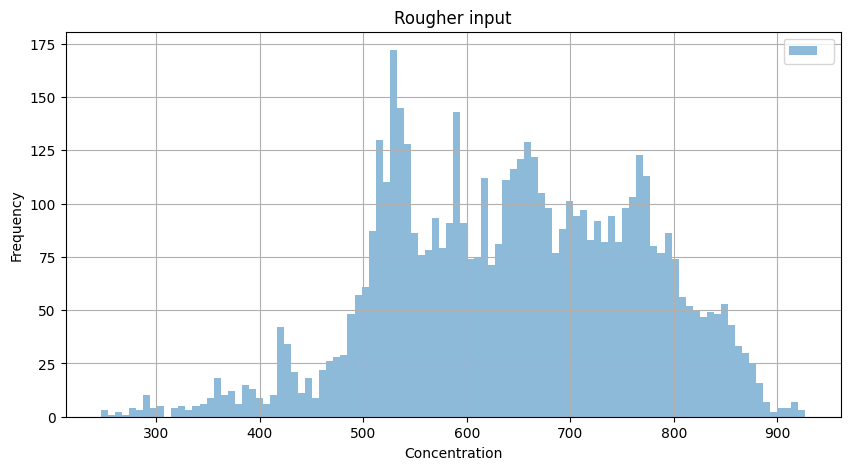

In [27]:
df_test_raw_input = [col for col in df_test.columns if 'rougher.input' in col] 
df_test_raw = df_test[df_test_raw_input].sum(axis=1)

Q1_test = df_test_raw.quantile(0.25)
Q3_test = df_test_raw.quantile(0.75)
IQR_test = Q3_test - Q1_test

print('This is the IQR:', IQR_test)

lower_bound_test = Q1_test - 1.5 * IQR_test
upper_bound_test = Q3_test + 1.5 * IQR_test

outlier_indices_test = df_test_raw[(df_test_raw < lower_bound_test) | (df_test_raw > upper_bound_test)].index

df_test_1 = df_test.drop(outlier_indices_test)

remaining_indices_test = df_test_1.index

df_test_raw_input_filtered = [col for col in df_test_1.columns if 'rougher.input' in col]
df_test_raw_filtered = df_test_1[df_test_raw_input_filtered].sum(axis=1)

print(df_test_raw_input_filtered)

df_test_raw_filtered.plot(kind='hist', bins=100, figsize=(10, 5), grid=True, legend=True, alpha=0.5)
plt.title('Rougher input')
plt.xlabel('Concentration')
plt.ylabel('Frequency')
plt.show()





Now we have a test and a train set ready to be used in our model.

## Model building

Just to clarify, we have removed the anormal values in the train set and in the test set.
And this are their variables:

- df_train_1 = train set without anormal values

- df_test_1 = test set without anormal values

In [28]:
print(df_train_1.columns)
print(df_test_1.columns)

Index(['date', 'final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.input.sulfate', 'primary_cleaner.input.depressant',
       'primary_cleaner.input.feed_size', 'primary_cleaner.input.xanthate',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'primary_cleaner.state.floatbank8_a_air',
       'primary_cleaner.state.floatbank8_a_level',
       'primary_cleaner.state.floatbank8_b_air',
       'primary_cleaner.state.floatbank8_b_level',
       'primary_clean

### Features and Target

In [29]:
features = df_test_1.columns.values
targets = ['rougher.output.recovery', 'final.output.recovery']

### Preparation of data for modeling

In [30]:
X_train = df_train_1[features].reset_index(drop = True)
y_train = df_train_1[targets].reset_index(drop = True)

y_train.columns = [0,1] # Here we are renaming the columns of y_train so we can use them in the cross_val_score function

y_train

,0,1
0,87.107763,70.541216
1,86.843261,69.266198
2,86.842308,68.116445
3,87.226430,68.347543
4,86.688794,66.927016
...,...,...
15387,89.574376,73.755150
15388,87.724007,69.049291
15389,88.890579,67.002189
15390,89.858126,65.523246


In [31]:
X_train.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,...,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,127.092003,10.128295,7.25,0.988759,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,...,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,125.629232,10.296251,7.25,1.002663,1576.166671,-500.904965,1575.950626,-499.865889,1575.994189,...,13.992281,-505.503262,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184
2,2016-01-15 02:00:00,123.819808,11.316280,7.25,0.991265,1601.556163,-499.997791,1600.386685,-500.607762,1602.003542,...,14.015015,-502.520901,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363
3,2016-01-15 03:00:00,122.270188,11.322140,7.25,0.996739,1599.968720,-500.951778,1600.659236,-499.677094,1600.304144,...,14.036510,-500.857308,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129
4,2016-01-15 04:00:00,117.988169,11.913613,7.25,1.009869,1601.339707,-498.975456,1601.437854,-500.323246,1599.581894,...,14.027298,-499.838632,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691


The date is not going to be used in our model so we are going to remove it.

In [32]:
X_train = X_train.drop(['date'], axis = 1)

### sMAPE

In [33]:
def compute_smape(y_true, y_pred):
    n = len(y_true)
    real = abs(y_true)
    pred = abs(y_pred)
    diff = abs(y_true - y_pred)
    smape =  (1/n)*np.sum(diff /((real + pred)/2))*100
    return abs(smape)

def smape_ponderado(y_true, y_pred):
    
    y_rougher = y_true.iloc[:,0]
    y_pred_rougher = y_pred[:,0]

    y_final = y_true.iloc[:,1]
    y_pred_final = y_pred[:,1]
    
    smape_rougher = compute_smape(y_rougher, y_pred_rougher)
    smape_final = compute_smape(y_final, y_pred_final)
    
    return abs(0.25*smape_rougher + 0.75*smape_final)

def smape_ponderado_df(y_true, y_pred):
    y_rougher = y_true.iloc[:,0]
    y_pred_rougher = y_pred.iloc[:,0]

    y_final = y_true.iloc[:,1]
    y_pred_final = y_pred.iloc[:,1]

    smape_rougher = compute_smape(y_rougher, y_pred_rougher)
    smape_final = compute_smape(y_final, y_pred_final)
    
    return abs(0.25*smape_rougher + 0.75*smape_final)




We need to use this function becasue we are loocking for a score.

In [34]:
smape_scorer = make_scorer(smape_ponderado, greater_is_better=False)

## Linear Regression

In [35]:
lr_model_v2 = LinearRegression()
lr_model_v2.fit(X_train, y_train)

LinearRegression()

In [36]:
lr_model = LinearRegression()
lr_scores = cross_val_score(lr_model, X_train, y_train, scoring = smape_scorer, cv = 5)

In [37]:
lr_final_score = lr_scores.mean()

print('Points for Linear Regression:', lr_final_score)
print('Linear Regression Model | sMAPE = {:.6f}'.format(lr_final_score))

Points for Linear Regression: -13.880602910651538
Linear Regression Model | sMAPE = -13.880603


## Random Forest

We are going to find the best parameters for our model, with the help of the GridSearchCV function.

In [38]:

# rf_model = RandomForestRegressor(random_state = 12345, n_estimators = 10)

# param_grid_rf = {
#    'n_estimators': [50, 100], 
#    'max_depth': [10, 20], 
#    'min_samples_split': [2, 5],
#    'min_samples_leaf': [1, 2],
#    'max_features': ['sqrt', 'log2']
#}

# grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score=np.nan)
# grid_search_rf.fit(X_train, y_train)

#print("Mejores parámetros encontrados: ", grid_search_rf.best_params_)

Best parameters for Random Forest: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_lead':2, 'min_samples_split': 5, 'n_estimators': 100}

In [39]:
rf_model_optimized = RandomForestRegressor(
    max_depth = 10,
    max_features = 'sqrt',
    min_samples_leaf = 1,
    min_samples_split = 2,
    random_state = 12345,
    n_estimators = 100)


rf_scores_optimized = cross_val_score(rf_model_optimized, X_train, y_train, scoring=smape_scorer, cv=5)
rf_final_score_optimized = rf_scores_optimized.mean()

print('Points sMAPE for each iteration:', rf_scores_optimized)
print('Random Forest Model | sMAPE = {:.6f}'.format(rf_final_score_optimized))


Points sMAPE for each iteration: [-11.37729806 -10.94140255 -11.9785985  -15.29167977 -11.03038932]
Random Forest Model | sMAPE = -12.123874


## Decision Tree

Here we are going to use gridsearch to find the best parameters for our model.

In [40]:
# dt_model = DecisionTreeRegressor(random_state = 12345)

# param_grid = {
#    'max_depth': [10, 20],
#    'min_samples_split': [2, 5],
#    'min_samples_leaf': [1, 2, 4],
#    'max_features': ['sqrt', 'log2']
# }

# grid_search = GridSearchCV(estimator=dt_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, error_score=np.nan)

# grid_search.fit(X_train, y_train)

# print("Best parameters found: ", grid_search.best_params_)


Best parameters found: {'max_depth': 10, 'max_features': 'sqrt, 'min_samples_leaf': 4, 'min_samples_split': 2}

In [41]:
dt_model_optimized = DecisionTreeRegressor(
    random_state=12345, 
    max_depth=10, 
    max_features='sqrt', 
    min_samples_leaf=4, 
    min_samples_split=2)

In [42]:

dt_scores_optimized = cross_val_score(dt_model_optimized, X_train, y_train, scoring = smape_scorer, cv = 5)

dt_final_score = dt_scores_optimized.mean()

print('Points sMAPE for each iteration:', dt_scores_optimized)
print('Model of Decision Tree | sMAPE = {:.6f}'.format(dt_final_score))

Points sMAPE for each iteration: [-14.63204296 -14.03017767 -13.05885774 -17.75048618 -13.3209008 ]
Model of Decision Tree | sMAPE = -14.558493


## Model Selection

This is the score for each model:

- Linear Regression: 13.880603

- Random Forest: 12.123874

- Decision Tree: 14.558493

Pretty similiar scores but the Random Forest model is the best one.

So we are going to use the Random Forest model to predict the test set.

## Model Testing

In [43]:
rf_model_optimized.fit(X_train, y_train)

X_test = df_test_1[features].drop(['date'], axis=1)
y_pred_test = rf_model_optimized.predict(X_test)



In [44]:

y_pred_test = pd.DataFrame(y_pred_test)

print(y_pred_test.isnull().sum())




0    0
1    0
dtype: int64


In [45]:
y_pred_test = y_pred_test.rename(columns={0: 'rougher.output.recovery', 1: 'final.output.recovery'})

In [46]:
y_pred_test['date'] = df_test_1['date'].values
y_pred_test = y_pred_test[['date', 'rougher.output.recovery', 'final.output.recovery']]


print(y_pred_test.sample(15))



                     date  rougher.output.recovery  final.output.recovery
2583  2016-12-27 10:59:59                86.993405              70.321684
2781  2017-09-07 23:59:59                78.111491              58.469003
2975  2017-09-16 01:59:59                79.482894              63.159310
1476  2016-11-10 14:59:59                78.371072              61.451927
4304  2017-11-12 12:59:59                72.139683              52.810811
4980  2017-12-11 00:59:59                79.304335              67.151478
3784  2017-10-21 07:59:59                82.652660              68.585021
4332  2017-11-13 16:59:59                83.422183              65.950034
3664  2017-10-16 02:59:59                84.221342              66.642661
3150  2017-09-23 12:59:59                79.428215              63.861370
3847  2017-10-23 22:59:59                87.147172              70.075992
1489  2016-11-11 09:59:59                63.601938              58.516991
445   2016-09-21 08:59:59             

In [47]:

y_pred_test = y_pred_test.rename(columns={'rougher.output.recovery': 'rougher.output.recovery_pred', 'final.output.recovery': 'final.output.recovery_pred'})


df_full = df_full.merge(y_pred_test, on='date', how='left')


df_full.head()


,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,...,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level,rougher.output.recovery_pred,final.output.recovery_pred
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,...,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980,NaN,NaN
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,...,11.950531,-501.331529,10.039245,-500.169983,7.984757,-500.582168,13.998353,-599.787184,NaN,NaN
2,2016-01-15 02:00:00,6.055926,10.213995,5.383759,42.657501,68.116445,10.507046,0.953716,16.208849,2.257889,...,11.912783,-501.133383,10.070913,-500.129135,8.013877,-500.517572,14.028663,-601.427363,NaN,NaN
3,2016-01-15 03:00:00,6.047977,9.977019,4.858634,42.689819,68.347543,10.422762,0.883763,16.532835,2.146849,...,11.999550,-501.193686,9.970366,-499.201640,7.977324,-500.255908,14.005551,-599.996129,NaN,NaN
4,2016-01-15 04:00:00,6.148599,10.142511,4.939416,42.774141,66.927016,10.360302,0.792826,16.525686,2.055292,...,11.953070,-501.053894,9.925709,-501.686727,7.894242,-500.356035,13.996647,-601.496691,NaN,NaN


In [48]:

df_full_valid = df_full.dropna(subset=['rougher.output.recovery', 'final.output.recovery'])

y_true = df_full_valid[['rougher.output.recovery', 'final.output.recovery']]
y_pred = df_full_valid[['rougher.output.recovery_pred', 'final.output.recovery_pred']] 


In [49]:
print(y_pred.iloc[15796:15797])
print(y_true.iloc[15796:15797])

       rougher.output.recovery_pred  final.output.recovery_pred
15796                     81.759457                   65.842445
       rougher.output.recovery  final.output.recovery
15796                92.440787              70.622773


In [50]:

smape_score = smape_ponderado_df(y_true, y_pred)
print('sMAPE:', smape_score)

sMAPE: 2.4885790240930437


With a sMAPE of 2.48% we can say that our model has a good prediction and can be used to predict the amount of gold extracted from the gold mineral.


## Conclusion

After thoroughly investigating the gold extraction process and analyzing the provided dataset, we now have a solid understanding of how the process works and how the data relates to it.

Throughout this project, we've successfully performed key tasks, including data exploration, building predictive models, and rigorously evaluating their performance.

Our predictive models can accurately estimate gold recovery at various processing stages, which is valuable for improving overall extraction efficiency. We've also used metrics like sMAPE to assess model accuracy.

In summary, this project has deepened our knowledge of gold mining and the application of machine learning for predicting important outcomes. As we continue to refine our models, we're well-equipped to make data-driven decisions to enhance future gold extraction efforts.

